# RNN models of Markov sequences

We'd like to understand recurrent neural network (RNN) modelling of sequences of items drawn from a finite alphabet.

By 'modelling' we'll assume two main aims:
<ol>
<li>
At each time step in an observed sequence, the model predicts the probability distribution for the next item, and is efficient in storage and runtime.
<li>
The structure of the model allows insight into the process that generates the sequence.
</ol>

Suppose, for example, that the alphabet has <i>N</i> distinct items, and that the process generating the sequence is Markov -- i.e. the state underlying each item depends only on its predecessor. In that case, problem 1 is completely solved in <i>O(N^2)</i> storage by just collecting enough data and observing conditional frequencies. This does nothing to address problem 2, however. On the other hand, fitting an <i>n</i>-state hidden Markov model (HMM) via Baum-Welch both reduces the storage to <i>O(nN)</i> (so improves the solution to problem 1) and addresses problem 2.

Of course, most sequences generated by processes of interest are not 1-st order Markov. If the process is Markov of order <i>k</i>, then storage requirement for the naive solution becomes <i>O(N^k)</i> and rapidly becomes intractable. This is where RNNs appear to be an attractive modelling tool. In a sense, fitting an HMM is akin to a linear model for a regression problem: in some cases it will be a good approximation, and will have low variance but high bias.

In this notebook I want to explore RNNs as a modelling tool. I'll start with first-order Markov data. In this case, the considerations above should inform what is a reasonable number of parameters for a model.

# Step 1: generate data from an HMM

In [92]:
import numpy as np
import numpy.random as rd
import string

alphabet = list(string.ascii_lowercase)
hyperparameter = 6

k = rd.poisson(hyperparameter) # nr states
family = [rd.choice(alphabet, size=rd.poisson(hyperparameter), replace=False) for i in range(k)]
for f in family: f.sort()
size = [len(f) for f in family]
distribution = [rd.dirichlet(np.ones(size[i])) for i in range(k)]
transition = np.ones([k,k])/float(k-1)/4.0
for i in range(k): transition[i,i] = 0.75

for f in family: print(f)

['d' 'f' 'q']
['a' 'b' 'c' 'd' 'h' 'm' 'p' 'u' 'w']
['j' 'l' 'q' 'r']
['c' 'd' 'e' 'h' 'k' 'l' 'm' 'n' 'p' 's']
['a' 'd' 'e' 'g' 'h' 'r' 's' 'u' 'x']
['b' 'e' 'f' 'h' 'j' 'k' 't']
['a' 'b' 'g' 'i' 'm' 'n' 'p' 'q' 't']


In [93]:
# generate data:
length = 10000

s = rd.choice(k)
state = [s]
for i in range(length):
    s = rd.choice(k, p=transition[s,:])
    state.append(s)

text = []
for i in range(length):
    text.append(rd.choice(family[state[i]], p=distribution[state[i]]))

In [94]:
from __future__ import print_function

chars = set(text)
print('# distinct characters:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# divide into training and test sets:
n_train = int(len(text)/2)
text_train = text[0:n_train]
state_train = state[0:n_train]
text_test = text[n_train:len(text)]

print('training length:', len(text_train))
print('test length:', len(text_test))

# distinct characters: 22
training length: 5000
test length: 5000


# Step 2: train and save an RNN model

In [29]:
# cut the text in semi-redundant sequences:

import helpers as hp

unroll = 20
X,y = hp.make_training_vectors(text_train, unroll=unroll, step=3)
print('# sequences:', len(y))

# sequences: 8327


In [ ]:
# experimental model build...

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, Recurrent

nhidden = [32]

model = Sequential()
model.add(LSTM(input_dim=len(chars),
               output_dim=nhidden[0], 
               return_sequences=True,
               inner_activation='hard_sigmoid',
               activation='tanh'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Exception: When using TensorFlow, you should define explicitly the number of timesteps of your sequences.
# If your first layer is an Embedding, make sure to pass it an "input_length" argument. 
# Otherwise, make sure the first layer has an "input_shape" or "batch_input_shape" argument, 
# including the time axis.

In [31]:
# build the model:

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, Recurrent

nhidden = [32]

model = Sequential()
if len(nhidden) == 2: 
    model.add(LSTM(nhidden[0], return_sequences=True, input_shape=(unroll, len(chars))))
    model.add(LSTM(nhidden[1], return_sequences=False))
else:
    model.add(LSTM(nhidden[0], return_sequences=False, input_shape=(unroll, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 20, 21)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (None, 32)                    6912                
Dropout (dropout)             (None, 32)                    0                   
Dense (dense)                 (None, 21)                    693                 
Activation (activation)       (None, 21)                    0                   
--------------------------------------------------------------------------------
Total params: 7605
--------------------------------------------------------------------------------


In [ ]:
model.fit(X, y, batch_size=128, nb_epoch=100, verbose=1)

In [33]:
import os

wt = model.get_weights()
version = 1
nh_str = "%d" % nhidden[0]
for i in range(1,len(nhidden)): nh_str += "_%d" % nhidden[i]
wkdir = "./data/rnn_%s_states_%d_version_%d" % (nh_str, k, version)

while os.path.isdir(wkdir): 
    version += 1
    wkdir = "./data/rnn_%s_states_%d_version_%d" % (nh_str, k, version)
os.mkdir(wkdir) 

np.savez("%s/data" % wkdir, 
         k=k, 
         family=family, 
         size=size, 
         distribution=distribution, 
         transition=transition,
         unroll=unroll,
         weights=wt,
         train=text_train,
         test=text_test,
         state=state_train,
         chars=list(chars)
        )

# Visual analysis of previously loaded data

The code should be self-contained beyond this point...

In [256]:
# if old data, otherwise omit:
wkdir = "./data/rnn_%s_states_%d_version_%d" % ("3",7,2)

In [257]:
# load data:

import numpy as np
import numpy.random as rd
import os

data = np.load("%s/data.npz" % wkdir)
k = data['k']
family = data['family']
size = data['size']
distribution = data['distribution']
transition = data['transition']
unroll = data['unroll']
wt = data['weights']
text_train = data['train']
text_test = data['train']  # 'test' if it exists, otherwise 'train'
state = data['state']
chars = set(data['chars'])
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# show a sample and family details:
print("Sample:")
samplelength = 200
start = rd.choice(len(text_train) - samplelength)
print(''.join(text_train[start:start+samplelength]))
print()
for i in range(k): print(zip(family[i], [round(p,3) for p in distribution[i]]))

Sample:
cujuuuucocurujecjuuucuuucnqqqgqgnsviyyqucuqgqgqgqnncccsywcqgqcccuuxgjxqxjhcocsiiirgrirriiiqmyigiriiiymsyivyyyyyswigrogqyyncncgqqqqqmyxnwcvsvivviccucjqqqqwigqqggogcctcxccncscccccccccqsuujucmsiyymarxxrr

[('i', 0.209), ('m', 0.021), ('s', 0.145), ('v', 0.137), ('w', 0.071), ('y', 0.417)]
[('a', 0.003), ('c', 0.243), ('g', 0.147), ('m', 0.184), ('o', 0.184), ('t', 0.098), ('x', 0.042), ('y', 0.063), ('z', 0.035)]
[('b', 0.006), ('c', 0.547), ('n', 0.273), ('s', 0.135), ('w', 0.038)]
[('g', 0.203), ('i', 0.364), ('j', 0.066), ('r', 0.367)]
[('g', 0.225), ('i', 0.005), ('n', 0.152), ('q', 0.618)]
[('a', 0.172), ('d', 0.037), ('g', 0.025), ('h', 0.058), ('i', 0.019), ('j', 0.114), ('q', 0.035), ('r', 0.266), ('s', 0.05), ('x', 0.224)]
[('c', 0.35), ('e', 0.073), ('j', 0.061), ('u', 0.516)]


In [20]:
# write families and distributions to file:
charfile = "%s/chars.txt" % wkdir
familyfile = "%s/families.txt" % wkdir
distfile = "%s/distributions.txt" % wkdir
cf = open(charfile, 'w')
for c in chars: cf.write("%c\n" % c)
cf.close()
ff = open(familyfile, 'w')
for f in family: ff.write("%s\n" % ''.join(f))
ff.close()
df = open(distfile, 'w')
for d in distribution:
    for x in d: df.write("%g " % x)
    df.write("\n")
df.close()

# and invoke R script to make pdf picture:
os.system("Rscript ./R/families.R %s" % wkdir)
print("See directory:", wkdir)

See directory: ./data/rnn_3_states_5_version_1


Our aim now is to read the output vector of length 32 as a time series, as we run the training sequence through the network. For this, we first need to remove the softmax layer -- or at least, duplicate the truncated network:

In [258]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, Recurrent

nhidden = [3] # should correspond to the directory name above

proj = Sequential()
if len(nhidden) == 2: 
    proj.add(LSTM(nhidden[0], return_sequences=True, input_shape=(unroll, len(chars))))
    proj.add(LSTM(nhidden[1], return_sequences=False))
else:
    proj.add(LSTM(nhidden[0], return_sequences=False, input_shape=(unroll, len(chars))))
proj.compile(loss='categorical_crossentropy', optimizer='rmsprop')
proj.set_weights(wt[:len(wt)-2])
proj.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, array(20), 22)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (None, 3)                     312                 
--------------------------------------------------------------------------------
Total params: 312
--------------------------------------------------------------------------------


So here's the time series of hidden unit activity:

In [259]:
import helpers as hp

X,y = hp.make_training_vectors(text_train, unroll=unroll, step=1)
activity = proj.predict(X)

tophidden = nhidden[len(nhidden) - 1]

if tophidden==2:
    proj_2d = activity
if tophidden>3:
    from tsne import bh_sne
    proj_2d = bh_sne(activity, theta=0.5) # check theta!

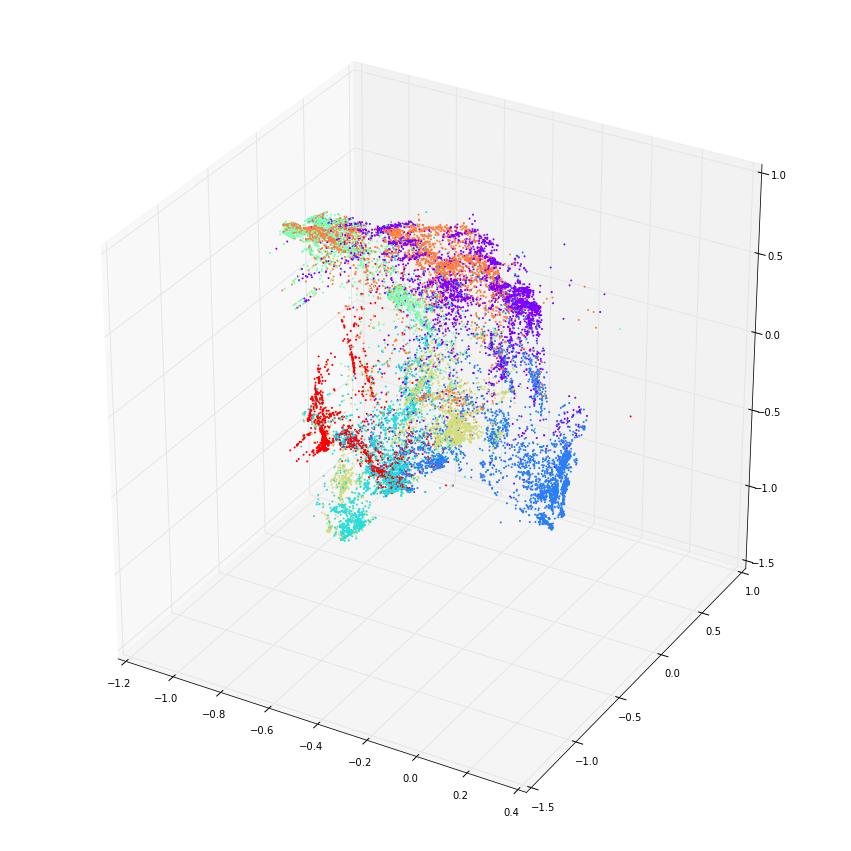

In [260]:
%matplotlib inline
import matplotlib.pyplot as plt

col = state[(unroll - 1):len(y)+unroll-1]

if tophidden==3:
    from mpl_toolkits.mplot3d import Axes3D
    #plt.switch_backend('Qt4Agg')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(activity[:,0], activity[:,1], activity[:,2],
               c=col, 
               cmap='rainbow', 
               edgecolors='face', 
               s=1.0,
               alpha=1.0)
    plt.show()
else:    
    plt.figure(figsize=(15,15))
    plt.scatter(proj_2d[:,0], proj_2d[:,1], 
            c=col, cmap='rainbow', edgecolors='face', s=1.0,
            alpha=1.0)
    plt.colorbar(ticks=range(k), shrink=0.5)
    plt.show()

# Model evaluation

In [ ]:
# reconstruct the original model:

from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
if len(nhidden) == 2: 
    model.add(LSTM(nhidden[0], return_sequences=True, input_shape=(unroll, len(chars))))
    model.add(LSTM(nhidden[1], return_sequences=False))
else:
    model.add(LSTM(nhidden[0], return_sequences=False, input_shape=(unroll, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.set_weights(wt)
model.summary()

In [247]:
# build HMM probability sequence:

# fix HMM matrices:
P_matrix = np.matrix(transition)
F_matrix = np.matrix(np.zeros([len(family), len(chars)]))
for i in range(len(family)):
    f = family[i]
    for j in range(len(f)):
        c = f[j]
        F_matrix[i,char_indices[c]] = distribution[i][j]

# perform alpha pass:
alpha = np.matrix(np.ones([len(text_test), k]))/k
for i in range(len(text_test)):
    if i==0:
        tmp = alpha[0] * P_matrix
    else: 
        tmp = alpha[i-1,:] * P_matrix
    y = char_indices[text_test[i]]
    alpha[i,:] = np.multiply(tmp, F_matrix[:,y].transpose())
    alpha[i,:] = alpha[i,:]/np.sum(alpha[i,:])

# infer HMM predictions:
hmm_pred = np.ones([len(text_test), len(chars)])/len(chars)
for i in range(1,len(text_test)):
    hmm_pred[i,:] = alpha[i-1,:] * P_matrix * F_matrix

In [248]:
# build RNN probability sequence:

X,y = hp.make_training_vectors(text_test, unroll=unroll, step=1)
rnn_pred = model.predict(X)

[ 0.0331984   0.01569288  0.00303471  0.0350626   0.20987116  0.00327333
  0.00292191  0.08760139  0.16002829  0.0178744   0.04136278  0.04696134
  0.03462707  0.21475276  0.00852182  0.0181354   0.00352126  0.06355842]
[ 0.02179118  0.01437331  0.00679071  0.01693738  0.23877611  0.00089821
  0.00303029  0.07651165  0.18698525  0.02820145  0.02218129  0.03178591
  0.01047401  0.26494213  0.01520867  0.00493358  0.01482431  0.04135457]
Mean variation:  0.0153591729635


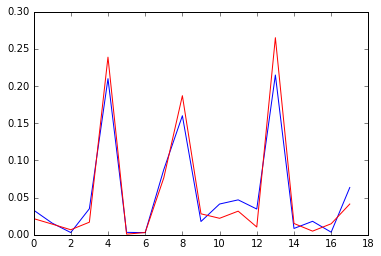

In [253]:
# compare probability predictions at a random time step:

from __future__ import print_function

def mean_variation(p1, p2):
    return sum(abs(p1 - p2))/len(p1)

idx = rd.randint(len(text_test) - unroll)
print(rnn_pred[idx,:])
print(hmm_pred[idx+unroll,:])

print("Mean variation: ", mean_variation(rnn_pred[idx,:], hmm_pred[idx,:]))
plt.plot(rnn_pred[idx,:], 'b-')
plt.plot(hmm_pred[idx,:], 'r-')
plt.show()

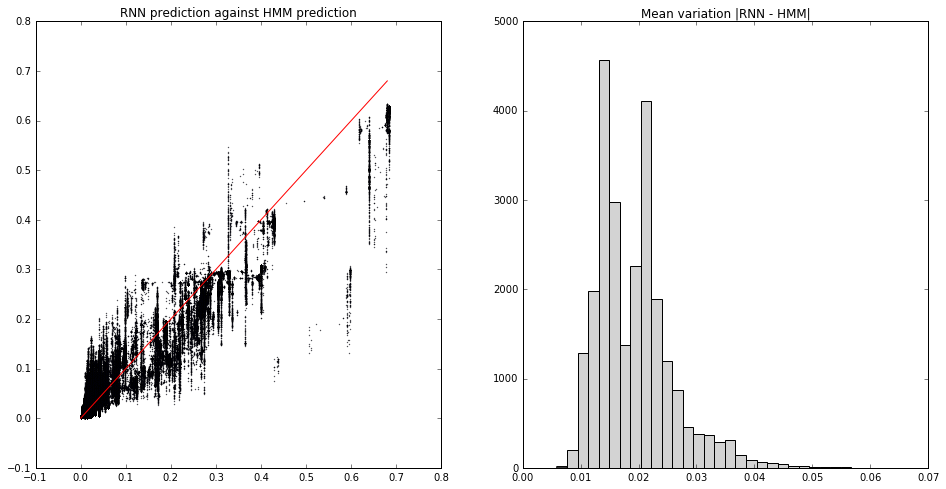

In [254]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1,2), (0, 1), colspan=1)

# plot RNN against HMM probabilities:
hprob = hmm_pred[unroll:,:].flatten()
rprob = rnn_pred.flatten()

mx = max(max(hprob), max(rprob))
idx = np.arange(0,mx,0.01)
ax1.plot(idx, idx, 'r-')
ax1.scatter(hprob, rprob, s=0.1)
ax1.set_title("RNN prediction against HMM prediction")

# histogram the mean variation between the two probability predictions:
mvar = [mean_variation(rnn_pred[i,:], hmm_pred[i+unroll,:]) for i in range(len(text_test) - unroll)]

ax2.hist(mvar, bins=30, color='lightgrey')
ax2.set_title("Mean variation |RNN - HMM|")
plt.show()

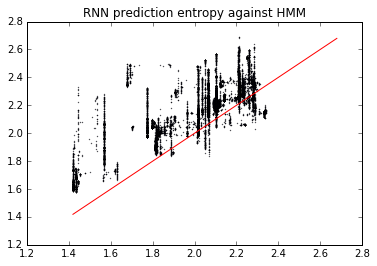

In [255]:
h_ent = [hp.entropy(hmm_pred[i,:]) for i in range(unroll, len(text_test))]
r_ent = [hp.entropy(rnn_pred[i,:]) for i in range(len(text_test)-unroll)]
mn = min(min(h_ent), min(r_ent))
mx = max(max(h_ent), max(r_ent))

idx = np.arange(mn, mx, (mx-mn)/100)
plt.plot(idx, idx, 'r-')
plt.scatter(h_ent, r_ent, s=0.1)
plt.title("RNN prediction entropy against HMM")
plt.show()

<function matplotlib.pyplot.show>

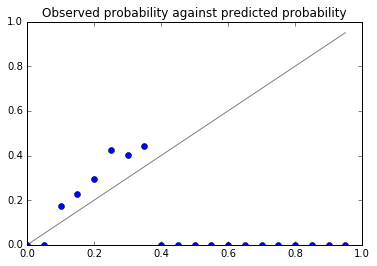

In [132]:
delta = 0.05
x = np.arange(0,1,delta)
y = np.zeros(len(x))
for i in range(len(x)):
    p = x[i]
    sub_df = df[(df.pred_prob >= p) & (df.pred_prob < p+delta)]
    if sub_df.shape[0]>0:
        y[i] = sub_df[sub_df.next == sub_df.pred].shape[0]/float(sub_df.shape[0])
    
plt.plot(x,x, c='grey')
plt.plot(x,y, 'bo')
plt.title("Observed probability against predicted probability")
plt.show